# Stochastic Gradient Descent

As in other regression models, we have to deal with the question of how to fit the parameters of an MLP. In the lingo of neural networks, we speak of **training the model**.

Recall from the [previous lecture](mlp.ipynb) that our goal is to minimize a loss function $\ell$ over training data $\{(x_i, y_i)\}_{i \le N}$:
$$L(w) = \frac1N \sum_{i \le N} \ell(y_i, f_w(x_i)).$$


However, even for convex $\ell$, the subtle dependency of $f$ on $w$ via a sequence of matrix multiplications and non-linearities means that we are facing a daunting non-convex optimization problem. In addition, the number of weights can easily scale into the millions. In this lecture, we discuss numerical methods to perform efficient optimization under these extreme conditions.

## Vanilla Gradient Descent

The most naïve numerical procedure for minimizing the loss function $L$ is **gradient descent**, where we iteratively change the weights by taking steps in the direction of the negative gradient $-\nabla_w L$ of the loss function:
$$w^{i+1} = w^{i} - \alpha \nabla_w L(w^{i}),$$
where $\alpha > 0$ is the **learning rate**. 

<img src="images/gradientDesc.png" alt="Drawing" style="width: 500px;"/>
https://developers.google.com/machine-learning/crash-course/reducing-loss/gradient-descent

The [Google Machine Learning Course](./images/learnRate.html) provides an enlightening illustration of gradient descent.

In contrast to the Newton-Raphson algorithm, the learning rate is not computed as a function of the current weights $w^{(i)}$, but rather tuned manually. A too high learning rate can cause instabilities and failure of convergence, a too small learning rate leads to slow convergence speed.

### Automatic Gradient Computation

If the MLP $f_w$ consists of many hidden layers, then computing the gradient by hand is painful. A key feature of `tensorflow` is the **automated gradient computation**.

In [1]:
library(ggplot2)
library(tensorflow)
library(keras)

Although it avoids a substantial amount of pain when it comes to forming derivatives, setting up the automatic gradient computation correctly requires a little bit of machinery. We illustrate this by computing the derivative of the square function $x \mapsto x^2$.

In [2]:
x <- k_placeholder()
square <- k_square(x)
grads <- k_gradients(square, x)

Under the hood, this sets up a **computational graph**, so that the engine knows how ``square`` depends on $x$. In order to actually perform the computation for specific input, we need to start a **session**.

In [3]:
sess = tf$Session()
sess$run(tf$global_variables_initializer())
sess$run(grads, feed_dict = dict(x=-5.2))

[[1]]
[1] -10.4

Now, we apply this principle to the linear model from the [previous lecture](./tensorflow.ipynb).

In [4]:
input_dim <- 5
input_size <- 2

x <- k_placeholder(c(input_size, input_dim))

lm <- keras_model_sequential() %>%
    layer_dense(1, input_shape = input_dim)
lm_ph <- lm(x)

As loss function, we use `mse`.

In [9]:
y <- k_placeholder(c(input_size))
learn_rate <- k_variable(1)

loss <- k_mean(k_square(y - lm(x)))

#extract weights from model
weights <- lm$trainable_weights[[1]]

#gradient of loss
grads <- k_gradients(loss, weights)[[1]]
grad_step <- k_update_sub(weights, learn_rate * grads)

With these dependencies set up, we are now ready to perform gradient descent for specific input. We first specify mock training data.


In [10]:
#fix mock input data and compute loss
set.seed(12)
x_inp = matrix(runif(input_dim * input_size), input_size)
y_inp = runif(input_size)

var_dict <- dict(x=x_inp, y=y_inp)

Now, we start a session and output the current weights, gradient and the associated loss.

In [11]:
#set up session
sess = tf$Session()
sess$run(tf$global_variables_initializer())

sess$run(weights, feed_dict = var_dict)
sess$run(grads, feed_dict = var_dict)

sess$run(loss, feed_dict = var_dict)

-0.51848340
0.71340919
0.02645874
0.60588360
0.92671943


-0.3463624418
0.0397177637
0.0134828379
-0.2509757280
0.0001818177


[1] 0.1541336

Then, we recompute the loss after applying a gradient step. Indeed, we see that the value has decreased!

In [201]:
sess$run(grad_step, feed_dict = var_dict)
sess$run(loss, feed_dict = var_dict)

0.3830212
0.9663973
0.5996777
0.4440495
0.4135252


[1] 0.2208779

#### 8.50

#### 9.50

## Stochastic Gradient Descent

We see that when working in a regime with plenty of training data, then computing gradients iteratively can be prohibitively time-consuming. The idea of **stochastic gradient descent (SGD)** is to select only a subset $J$  of all training indices. The associated sub-sample is called **mini-batch**. Instead of computing the loss based on all training data, only the data in the mini-batch is used. That is, 
$$L_{\mathsf{SGD}}(w) = \sum_{i \in J} \ell(y_i, f_w(x_i)).$$


However, even with unlimited computational resources, we would typically prefer SGD over full gradient descent, since the implicit randomization helps to prevent overfitting.

### Under the Hood: Backpropagation

We see that `tensorflow` does a great job computing gradients for us. But what actually happens, when calling `k_gradients`? [Recall](./mlp.ipynb) that an MLP can be written in the form
$$f_W(x) = a_L(W_L \cdot a_{L-1}(W_{L-1}\cdots (W_2 \cdot a_1(W_1 \cdot x + b_1) + b_2)\cdots) + b_{L})$$
with weights $W_i \in \mathbb{R}^{\ell_i \times \ell_{i-1}}$, biases $b_i \in \mathbb{R}^{\ell_i}$ and activation functions $a_i:\mathbb{R}^{\ell_i} \to \mathbb{R}^{\ell_i}$.

We can write $f_W$ more succinctly as a composition of functions 
$$f_W(x) = f^{(L)}_{W_L, b_L}(\cdots (f^{(2)}_{W_2, b_2}(f^{(1)}_{W_1, b_1}(x)))),$$
where $f^{(i)}_{W_i, b_i}(z) = a_i(W_i z + b_i)$. Since $f$ is a composition of functions, the gradients can now be computes by invoking the chain rule. This technique of automatic differentiation is called **backpropagation** and goes back to a [seminal paper](https://www.nature.com/articles/323533a0) by David E. Rumelhart, Geoffrey E. Hinton & Ronald J. Williams published in 1986.

The [Google Machine Learning Crashcourse](./images/backProp.html) provides a beautiful illustration for backpropagation.

We explain the general idea in the case where $L = 2$ without biases: $b_2 = b_1 = 0$. Since $a_2$ is typically a loss function, we assume the last layer to be one-dimensional, i.e., $\ell_2=1$. To simplify notation, we write $\ell = \ell_1$ and $p = \ell_0$. Hence, $W_2 = (w_{2;1}, w_{2;2}, \ldots, w_{2;\ell})$.

Writing $\big(f^{(1)}_{W_1}(x)\big)_k$ for the $k$th component of $f^{(1)}_{W_1}(x)$, the chain rule gives that
$$\begin{align*}
\frac{\partial}{\partial w_{2;j}}f_W(x)&= \frac{\partial}{\partial w_{2;j}}a_2\Big(W_2 f^{(1)}_{W_1}(x)\Big)\\
&= a_2'\Big(W_2 f^{(1)}_{W_1}(x)\Big) \frac{\partial}{\partial w_{2;j}}\sum_{k \le \ell} w_{2;k} 
\big(f^{(1)}_{W_1}(x)\big)_k\\
&= a_2'\Big(W_2 f^{(1)}_{W_1}(x)\Big)\big(f^{(1)}_{W_1}(x)\big)_j
\end{align*}$$
Hence, 
$$\nabla_{W_2} f_W(x) =  a_2'(W_2 f^{(1)}_{W_1}(x))f^{(1)}_{W_1}(x).$$

Note that the expressions $W_2 f^{(1)}_{W_1}(x)$ and $f^{(1)}_{W_1}(x)$ were already evaluated when computing $f_W(x) = a_2(W_2 f_{W_1}^{(1)}(x))$

The computation of the partial derivatives with respect to $W_1$ is similar with the exception that we now also have to apply the chain rule for $g_{W_1}^{(1)}$:
$$\frac{\partial}{\partial w_{1;i,j}}a_2(W_2 f^{(1)}_{W_1}(x)) = a_2'\Big(W_2 f^{(1)}_{W_1}(x)\Big) \frac{\partial}{\partial w_{1;i,j}}\Big(W_2 f^{(1)}_{W_1}(x)\Big)= a_2'\Big(W_2 f^{(1)}_{W_1}(x)\Big) W_2 \frac{\partial}{\partial w_{1;i,j}}f^{(1)}_{W_1}(x)$$

Note that we again have already computed $a_2'\Big(W_2 f^{(1)}_{W_1}(x)\Big)$ when computing gradients with respect to $W_2$. Hence, we can proceed recursively and it only remains to compute the gradients for $f^{(1)}_{W_1}$.

The above calculations already provide a very strong hint that when computing $f(x)$ and its gradients $f(x)$ many intermediate should be stored and re-used at a later stage. More precisely, the training via SGD decomposes into a **forward pass** and a **backward pass**.

#### Forward Pass

First, we compute $f_W(x)= f^{(L)}_{W_L}(\cdots (f^{(2)}_{W_2}(f^{(1)}_{W_1}(x))))$ recursively:

* compute $f^{(1)}_{W_1}(x)$ and save the value as $h^{(1)}$
* compute $f^{(2)}_{W_2}(h^{(1)})$ and save the value as $h^{(2)}$
* continue recursively until arriving at $f_W(x) = f^{(L)}_{W_L}(h^{(L-1)})$

This is **forward phase** where we start with the computation of the innermost expression and make our way forward until arriving at the outermost position.

#### Backward Pass

In the **backward pass**, the gradients $\nabla_W f_W(x)$ are computed via the chain rule. We put  $g^{(i)}_{W_i}(z) = a_i'(W_i z)$. Here, we start by computing the outermost expressions and make our way to the innermost expression. 
* To compute $\nabla_{W_L} f_W(x)$, we proceed as above to see that $\nabla_{W_L} f_W(x) = g^{(L)}_{W_L}\big(h^{(L-1)}\big) \cdot h^{(L-1)}$. 
* To compute $\nabla_{W_{L-1}} f_W(x)$, we proceed as above to see that $\nabla_{W_{L-1}} f_W(x) =  g^{(L)}_{W_L}\big(h^{(L-1)}\big) \cdot W_L\cdot \nabla_{W_{L-1}} f^{(L-1)}_{W_{L-1}}\big(h^{(L-2)}\big)$.  We store the expression $ g^{(L)}_{W_L}\big(h^{(L-1)}\big)$.
* To compute  $\nabla_{W_{L-2}} f_W(x)$, we proceed as above to see that 
$$\nabla_{W_{L-2}} f_W(x) = g^{(L)}_{W_L}(h^{(L-1)}) \cdot W_L\cdot g^{(L-1)}_{W_{L-1}}(h^{(L-2)}) \cdot W_{L-1} \cdot \nabla f_{W_{L-2}}^{(L-2)}(h^{(L-3)}).$$
We can reuse the expression $ g^{(L)}_{W_L}\big(h^{(L-1)}\big)$ f_Wrom the previous step and store additionally the expression $ g^{(L-1)}_{W_{L-1}}\big(h^{(L-2)}\big)$.

You already see that the computations can get rather involved. All the details are presented in  [Chapter 6.5 of the monograph on Deep Learning](http://www.deeplearningbook.org/) by  Aaron Courville, Ian J. Goodfellow, and Yoshua Bengio.

The upshot of the backpropagation algorithm is that one training step in the backpropagation algorithm takes essentially one forward pass and one backward pass through the network. Hence, it takes roughly twice as long as a simple evaluation. However, as we will see in the practical examples, many passes over the data might be needed until the weights have converged.

## Vanishing & Exploding Gradients

Now, that we have walked through SGD, we can understand better why it was not possible to build deep nets in the 1980s and 1990s.

The chain rule causes many multiplications as a gradient travels through the multiple layers. If the multiplications are not precisely fine-tuned, then the gradients become numerically unstable. To understand what happens when plugging in numerically unstable values into a sigmoid function, let's plot it once more. 

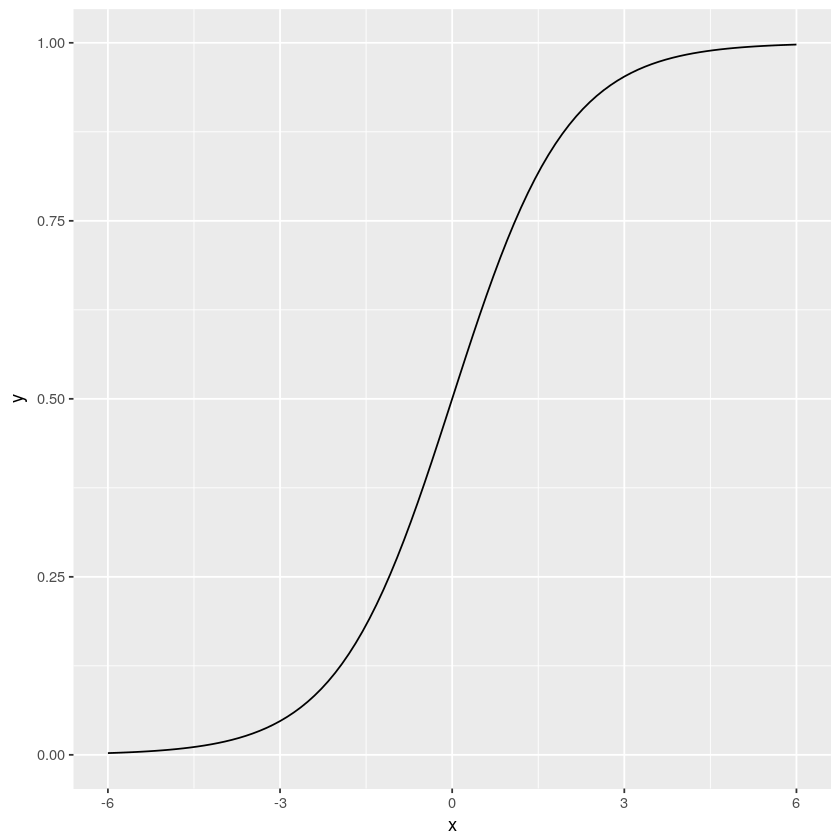

In [1]:
library(ggplot2)
library(tensorflow)
tfe_enable_eager_execution(device_policy = "silent")

ggplot(data = data.frame(x = 0), mapping = aes(x = x)) + 
 stat_function(fun = function(x) tf$sigmoid(x)$numpy()) +
 xlim(-6,6)


Inserting large values into the sigmoid throws us into a region where the function is almost flat, so that the gradients become essentially 0. In particular, any information collected by the backpropagation algorithm is lost after this point. 

One embarassingly simple solution to this problem is to replace the sigmoid with the activation function $\max(x, 0)$, also known as **Rectified Linear Unit (ReLU)**.

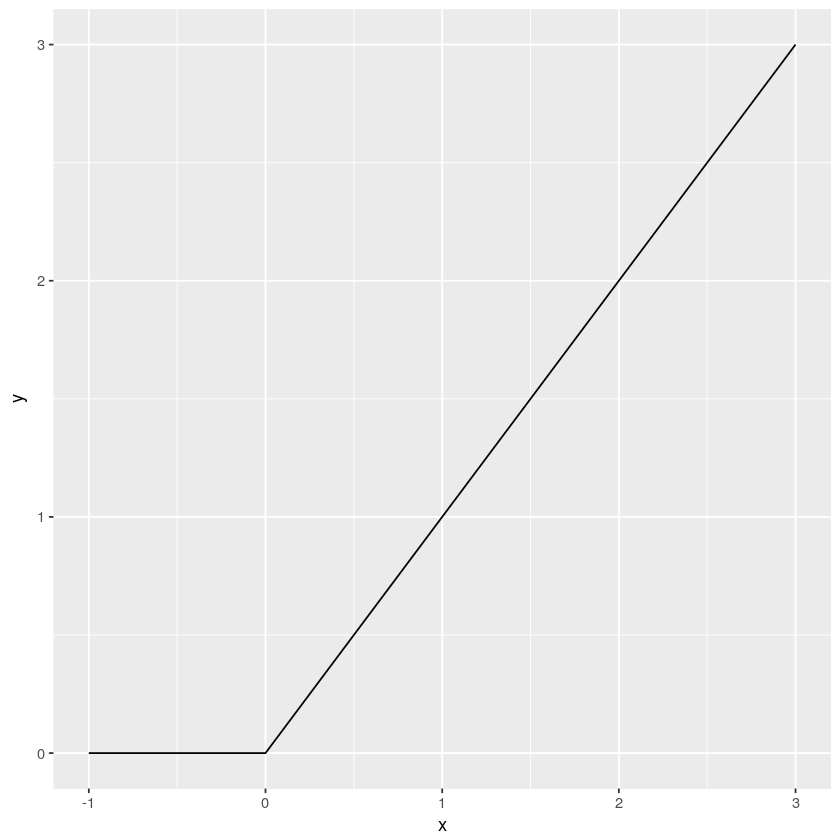

In [2]:
ggplot(data = data.frame(x = 0), mapping = aes(x = x)) + 
 stat_function(fun = function(x) tf$nn$relu(x)$numpy()) +
 xlim(-1,3) +
 ylim(0,3)


#### 10.25

#### 11.20

## SGD ++

So far, we have encountered stochastic-gradient descent (SGD) as the standard method to fit neural networks to data. Despite its simplicity, SGD is still the foundation of many state-of-the-art optimizers. In this notebook, we learn how to improve speed and accuracy of SGD with simple tricks.

### Adagrad

After several iterations of SGD the weights gradually approach the optimum. However, at a certain point the gradient steps become too coarse to achieve further improvements. Once this happens, the learning rate should be reduced to arrive at a better approximation.

 **Adagrad**, developed by [John Duchi, Elad Hazan, Yoram Singer](http://jmlr.org/papers/v12/duchi11a.html), achieves this goal by reducing the learning rate with successive gradient steps. 

More precisely, writing $g^j = \nabla \ell(w^j)$ for the gradient of the loss function in the $j$th iteration, we let 
$$G^i = {\sum_{j \le i} (g^j)^2}$$
denote the sum of squared gradients in the first $i$ steps. Then, the Adagrad update step becomes
$$w^{i+1} = w^{i} - \frac\alpha{\sqrt{G^{i}}}g^{i}.$$

In the actual implementation, Adagrad introduces a separate learning rate for each weight, so as to take into account situations where some converge faster than others.

### RMSProp

In practice, Adagrad often results in a highly aggressive reduction of the learning rate and therefore into slow learning. **RMSProp** developed by [Geoff Hinton](https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf) resolves this problem by replacing the sum of squared gradients with a moving average:
$$G^{i+1} = .9 \, G^{i} + .1\, ( g^{i})^2.$$

As before, we put
$$w^{i+1} = w^{i} - \frac\alpha{\sqrt{G^{i}}}g^{i}.$$

### Momentum

**Momentum** is a [classical technique](https://www.sciencedirect.com/science/article/pii/0041555364901375?via%3Dihub) in optimization to dampen oscillations appearing in the course of gradient descent:

<img src="images/momentum.png" alt="Drawing" style="width: 500px;"/>
https://distill.pub/2017/momentum/

The idea is to smoothen the gradients by replacing gradients via moving averages. Using a parameter $\beta<1$, we introduce the momentum vector
$$m^{i+1} = \beta m^i + g^i.$$
and define the update step via
$$w^{i+1} = w^i - \alpha m^i.$$

Gabriel Goh's [Distill article](https://distill.pub/2017/momentum/) provides beautiful interactive illustrations and a mathematical proof for momentum on the vanilla SGD. 

### Adam

**Adam** was developed by [Diederik P. Kingma and Jimmy Ba](https://arxiv.org/abs/1412.6980) and augments RMSProp with momentum. More precisely, we put
$$z^{i+1} = \beta_1 m^i + (1 - \beta_1) g^i,$$
$$G^{i+1} = \beta_2 G^i + (1 - \beta_2) (g^i)^2,$$

and then define the update step
$$w^{i+1} = w^i - \frac\alpha{\sqrt{G^i}}m^i.$$

The actual implementation also contains bias-corrections for $m^i$ and $G^i$.


### Second-Order Methods?

In classical optimization gradient descent approaches are typically superseded by methods incorporating information on the Hessian, such as the Newton-Raphson algorithm. This has the advantage of speeding up convergence substantially. There are three problems, why this reasoning does not carry over to deep learning.

1. Even moderately-sized networks consist of millions of weights, so that the number of entries in the Hessian goes into the trillions. This means the death, unless highly sophisticated heuristics are used to reduce the number of weights. 
2. The Hessian is typically [ill-conditioned in deep learning](https://arxiv.org/abs/1706.04454). That is, the vast majority of eigenvalues are close to 0 and matrix inversion is numerically volatile. 
3. The number of training examples that are available nowadays is typically very large, in particular if techniques like data augmentation are used. Spending more computational time on refined optimization methods means that the algorithm can see less training data. Experience shows that the time gained by faster convergence is typically not worth the price paid by seeing less examples.  

### Optimization in Keras

Keras makes it very convenient to specify the optimization algorithm to be used:

In [2]:
library(keras)

input_dim <- 5
hidden_dim <- 32

lm <- keras_model_sequential() %>% 
  layer_dense(units=32, input_shape = input_dim) %>%
  layer_dense(units=1, activation='sigmoid')

lm %>%
    compile(optimizer=optimizer_adam(lr=1e-3), 
            loss='binary_crossentropy')